##### Resources FB Prophet
- https://sungkim11.medium.com/forecast-sales-using-prophet-with-regressors-b19adf8080ab
- https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57
- https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-fbprophet-66147f049e66
- https://www.analyticsvidhya.com/blog/2022/04/an-end-to-end-guide-on-time-series-forecasting-using-fbprophet/
- https://facebook.github.io/prophet/docs/quick_start.html
- https://www.jadsmkbdatalab.nl/forecasting-with-facebook-prophet-models-an-intro/

  ##### Algo comparison
- Neptune.AI: https://neptune.ai/blog/arima-vs-prophet-vs-lstm
- Kaggle: https://www.kaggle.com/code/aaronfloreani/forecasting-btc-arima-xgboost-prophet-lstm
- YouTube: https://www.youtube.com/watch?v=0gXeXtL_KjY

##### Notes
- Difference between prophet & fbprophet: (From v0.6 onwards, Python 2 is no longer  supported. As of v1.0, the package name on PyPI is "prophet"; prior to v1.0 it was "fbprophet".)
- For prediction windows we use cross validation, this is applicable to the trainig data.
- Making predictions on the test-set that has regressors is a 'cheat', as we are predicting data we can already see. (https://sungkim11.medium.com/forecast-sales-using-prophet-with-regressors-b19adf8080ab)

In [1]:

#import util
import logging
import warnings
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot


logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

/Users/shephardmarufu/opt/anaconda3/envs/explore/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/pyn_m.csv')
df.head()
#df.describe().transpose()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
#Split Training and testing data automatically by percentage insted of manually by dates.
x=df['ds']
y=df['y']
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
train_df.tail()

,ds,y
2319,2014-06-11,7.439559
2320,2014-06-12,7.707962
2321,2014-06-13,7.350516
2322,2014-06-14,7.322510
2323,2014-06-15,7.285507


Hyperparameter tuning

##### Lasso Regression = L1, Ridge Regression = L2
- Because prophet has many places possible places for rate change, it uses L1 regularization
- By default changepoints are only inferred for the first 80% of the time series
 - If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

In [5]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
#create cutoff dates
cutoffs = pd.to_datetime(['2013-02-15', '2013-03-15', '2013-04-15']) #Manually select dates 30 days apart
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [6]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

11:20:59 - cmdstanpy - INFO - Chain [1] start processing
11:21:02 - cmdstanpy - INFO - Chain [1] done processing
11:21:04 - cmdstanpy - INFO - Chain [1] start processing
11:21:04 - cmdstanpy - INFO - Chain [1] start processing
11:21:04 - cmdstanpy - INFO - Chain [1] start processing
11:21:04 - cmdstanpy - INFO - Chain [1] done processing
11:21:04 - cmdstanpy - INFO - Chain [1] done processing
11:21:05 - cmdstanpy - INFO - Chain [1] done processing
11:21:05 - cmdstanpy - INFO - Chain [1] start processing
11:21:05 - cmdstanpy - INFO - Chain [1] done processing
11:21:07 - cmdstanpy - INFO - Chain [1] start processing
11:21:07 - cmdstanpy - INFO - Chain [1] start processing
11:21:07 - cmdstanpy - INFO - Chain [1] start processing
11:21:07 - cmdstanpy - INFO - Chain [1] done processing
11:21:07 - cmdstanpy - INFO - Chain [1] done processing
11:21:07 - cmdstanpy - INFO - Chain [1] done processing
11:21:08 - cmdstanpy - INFO - Chain [1] start processing
11:21:08 - cmdstanpy - INFO - Chain [1]

In [7]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

#best params
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [8]:
#Add country holidays model.add_country_holidays(country_name='UK')
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10.0) #Use best parameters
model.add_country_holidays(country_name='US')
model.fit(train_df)

11:22:06 - cmdstanpy - INFO - Chain [1] start processing
11:22:06 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = model.make_future_dataframe(periods=30, freq='D') #makefuture dataframe 30 days
forecast = model.predict(future)
plot_plotly(model, forecast)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2007, 12, 10, 0, 0),
                          datetime.datetime(2007, 12, 11, 0, 0),
                          datetime.datetime(2007, 12, 12, 0, 0), ...,
                          datetime.datetime(2014, 6, 13, 0, 0),
                          datetime.datetime(2014, 6, 14, 0, 0),
                          datetime.datetime(2014, 6, 15, 0, 0)], dtype=object),
              'y': array([9.59076114, 8.51959032, 8.18367658, ..., 7.35051617, 7.32251043,
                          7.28550655])},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2007, 12, 10, 0, 0),
                          datetime.datetime(2007, 12, 11, 0, 0),
                          datetime.datetime(2007, 12, 12, 0, 0), ...,
                          datetime.datetime(2014, 7, 13, 0, 0),
                          datetime.datetime(2014, 7, 14, 0, 0),
                          datetime.datetime(2014, 7, 15, 0, 0)], dtype=object),
              'y': array([8.14366487, 7.92204368, 7.73779113, ..., 7.13403762, 7.41503193,
                          7.1676187 ])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'Predicted',
              'type': 'scatter',
              'x': array([datetime.datetime(2007, 12, 10, 0, 0),
                          datetime.datetime(2007, 12, 11, 0, 0),
                          datetime.datetime(2007, 12, 12, 0, 0), ...,
                          datetime.datetime(2014, 7, 13, 0, 0),
                          datetime.datetime(2014, 7, 14, 0, 0),
                          datetime.datetime(2014, 7, 15, 0, 0)], dtype=object),
              'y': array([8.76775478, 8.52077481, 8.33395352, ..., 7.73837253, 8.01909548,
                          7.79576665])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2007, 12, 10, 0, 0),
                          datetime.datetime(2007, 12, 11, 0, 0),
                          datetime.datetime(2007, 12, 12, 0, 0), ...,
                          datetime.datetime(2014, 7, 13, 0, 0),
                          datetime.datetime(2014, 7, 14, 0, 0),
                          datetime.datetime(2014, 7, 15, 0, 0)], dtype=object),
              'y': array([9.35923733, 9.18099402, 8.95891181, ..., 8.33865199, 8.62257889,
                          8.3659975 ])}],
    'layout': {'height': 600,
               'showlegend': False,
               'template': '...',
               'width': 900,
               'xaxis': {'rangeselector': {'buttons': [{'count': 7, 'label': '1w', 'step': 'day', 'stepmode': 'backward'},
                                                       {'count': 1,
                                                        'label': '1m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 6,
                                                        'label': '6m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 1, 'label': '1y', 'step': 'year', 'stepmode': 'backward'},
                                                       {'step': 'all'}]},
                         'rangeslider': {'vi

##### Cross validation
- Horizon: the time to be predicted
-  Initial: the initial training period
- Period: the spacing between cut-off dates

In [11]:
#Here we do cross-validation to assess prediction performance on a horizon of 30 days,
# starting with 730 days of training data in the first cutoff and then making predictions after every  180 days.

df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '30 days')
df_cv.tail()

  0%|          | 0/9 [00:00<?, ?it/s]11:25:13 - cmdstanpy - INFO - Chain [1] start processing
11:25:13 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:03,  2.49it/s]11:25:14 - cmdstanpy - INFO - Chain [1] start processing
11:25:14 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:02,  2.67it/s]11:25:14 - cmdstanpy - INFO - Chain [1] start processing
11:25:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:01<00:02,  2.18it/s]11:25:15 - cmdstanpy - INFO - Chain [1] start processing
11:25:15 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:01<00:02,  2.15it/s]11:25:15 - cmdstanpy - INFO - Chain [1] start processing
11:25:15 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:02<00:02,  1.87it/s]11:25:16 - cmdstanpy - INFO - Chain [1] start processing
11:25:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [00:03<00:01,  1.70it/s]11:25:16 - cmds

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
260,2014-06-11,7.355170,6.744861,7.944751,7.439559,2014-05-16
261,2014-06-12,7.338611,6.752425,7.973845,7.707962,2014-05-16
262,2014-06-13,7.331960,6.736804,7.991645,7.350516,2014-05-16
263,2014-06-14,7.119899,6.539264,7.713275,7.322510,2014-05-16
264,2014-06-15,7.476671,6.833398,8.056705,7.285507,2014-05-16


In [12]:
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

###### Plot Cross Validation

Text(2010-02-07 00:00:00, 6, 'Horizon')

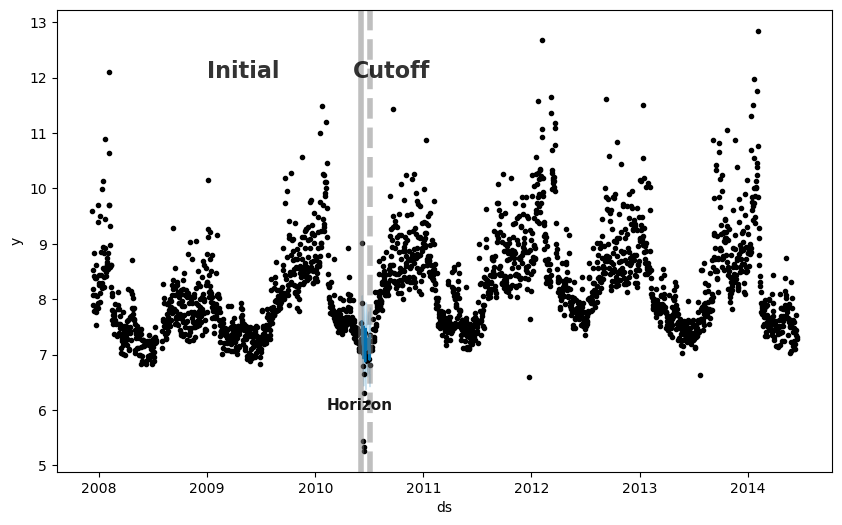

In [13]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(model.history['ds'].values, model.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2009-01-01'),y=12, s='Initial', color='black', #Initial training period 730 days
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2010-05-07'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('30 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2010-02-07'),y=6, s='Horizon', color='black',
       fontsize=11, fontweight='bold', alpha=0.9)

##### Perfomance metrics

In [14]:
perf_df = performance_metrics(df_cv)
perf_df.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,1.383508,1.176226,0.982300,0.111447,0.111447,0.120871,0.5
1,3 days,1.327294,1.152082,0.815699,0.090466,0.090466,0.099434,0.5
2,4 days,0.010658,0.103239,0.074048,0.010533,0.010533,0.010426,1.0
3,5 days,0.075535,0.274836,0.253103,0.036877,0.036877,0.036087,1.0
4,6 days,1.167677,1.080591,0.922672,0.162822,0.162822,0.145782,0.5


In [ ]:
#Plot change points
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
#Checkout holidays included in model training (model.train_holiday_names)
model.train_holiday_names

In [ ]:
fig = model.plot_components(forecast)